In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from collections import Counter
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
from pylab import *
from copy import deepcopy
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  recall_score, f1_score, precision_score
import seaborn as sns
import cv2
import numpy as np
from pathlib import Path
from PIL import Image, ImageStat
plt.ion()  

from pylab import rcParams
rcParams['figure.figsize'] = 6,6

device = torch.cuda.is_available()
if device:
    print("Using CUDA")
cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using CUDA


In [0]:
data_dir = '/content/drive/My Drive/Thesis/Humerus/'
TEST = 'test'
TRAIN = 'train'
VAL = 'validate'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True, num_workers=8
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 1104 images under train
Loaded 288 images under validate
Loaded 167 images under test
Classes: 
['0', '1']


In [0]:
test_dataloader=torch.utils.data.DataLoader(image_datasets[TEST], shuffle=False,num_workers=4)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


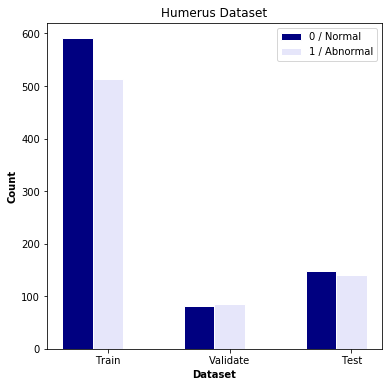

In [0]:
def countSamples(image_datasets):
  zerosList=[]
  onesList=[]
  for x in [TRAIN,TEST, VAL]:
      c=Counter(elem[1] for elem in image_datasets[x].imgs)
      l=list(c.items())
      if l[0][0]==0:
          zerosList.append(l[0][1])
      if l[1][0]==1:
          onesList.append(l[1][1])
  return zerosList,onesList
     
zerosList,onesList=countSamples(image_datasets)

bar1 = np.arange(len(onesList))
bar2 = [x + 0.25 for x in bar1]
plt.bar(bar1, zerosList, color='navy', width= 0.25,edgecolor='white',  label='0 / Normal')
plt.bar(bar2, onesList, color='lavender', width= 0.25, edgecolor='white', label='1 / Abnormal')
N = 3
ind = np.arange(N)
ax = plt.subplot(111)
ax.set_xticks(ind+0.25)
ax.set_xticklabels( ('Train', 'Validate','Test') )
plt.title('Humerus Dataset') 
plt.xlabel('Dataset', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend()
#plt.savefig('/content/drive/My Drive/Thesis/Data/Wrist/countplot.png')
plt.show()

<Figure size 720x720 with 0 Axes>

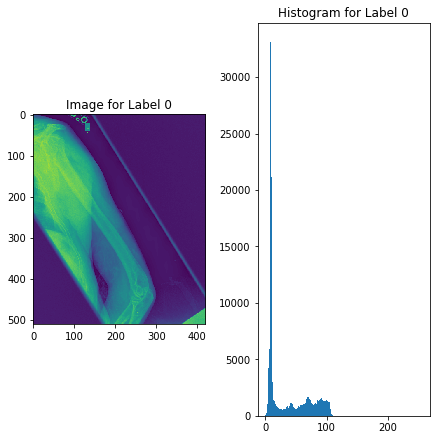

In [0]:
def plotHistograms(image,title):
 
  fig=plt.figure(figsize=(10, 10))
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,constrained_layout=True)
  img=cv2.imread(image,0)
  ax1.imshow(img)
  ax1.set_title("Image for Label %i" % title)  
  
  ax2.hist(img.ravel(),256,[0,256]); 
  ax2.set_title("Histogram for Label %i" % title)
  #fig.savefig('/content/drive/My Drive/Thesis/Data/Wrist/histogram.png')
  plt.show()

img=image_datasets[TRAIN]  
plotHistograms(img.imgs[0][0],img.imgs[0][1])
#plotHistograms(img.imgs[1][0],img.imgs[0][1])

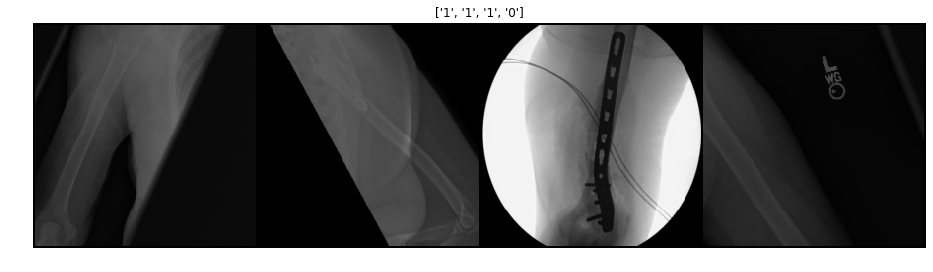

In [0]:
def displayImage(inp,title=None):
   inp = inp.numpy().transpose((1, 2, 0))   
   plt.figure(figsize=(16, 16))
   plt.axis('off')
   plt.imshow(inp)
   if title is not None:
        plt.title(title) 
   plt.pause(0.001)

def displayBatch(img,label):
   out = torchvision.utils.make_grid(img)
   displayImage(out,title=[class_names[x] for x in label])
   #print(out)
img,label=next(iter(dataloaders[TRAIN]))
displayBatch(img,label)

In [0]:
def plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,title):
 
  fig = plt.figure(figsize=(10, 6))
  fig.suptitle(title)
  ax =plt.subplot(1,2,1)

  ax.plot(train_acc_list, label="Train Accuracy")
  ax.plot(val_acc_list, label="Validation Accuracy")
  ax.legend()
  ax.set_xlabel('Number of Epochs')
  ax.set_ylabel("Accuracy")
  ax.set_title("Accuracy Graph")
  
  ax1=plt.subplot(1,2,2)

  ax1.plot(train_loss_list, label="Train Loss")
  ax1.plot(val_loss_list, label="Validation Loss")
  ax1.legend()
  ax1.set_xlabel('Number of Epochs')
  ax1.set_ylabel("Loss")
  ax1.set_title("Loss Graph")
  plt.show()

In [0]:
def train_model(model, criterion, optimizer, num_epochs=20):
    start=time.time()
    result_dict={}
    train_loss_list,train_acc_list=[],[]
    val_loss_list,val_acc_list=[],[]
    f1_score_list=[]
    predicted=[]
    actual=[]
    for epoch in range(num_epochs):
     
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
 
        for phase in [TRAIN,VAL]:
          
            if phase == TRAIN:
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == TRAIN:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase==VAL:
                  #  print("Pred",preds.cpu().numpy())
                  #  print("Lab",labels.cpu().numpy())
                  #  c=labels.cpu().numpy()
                    
                    actual.append(labels.cpu().detach().numpy().tolist())
                    predicted.append(preds.cpu().detach().numpy().tolist())
                
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            
            if phase == TRAIN:
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc) 
                
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
    
    flattened_predicted = [y for x in predicted for y in x]
    flattened_actual = [y for x in actual for y in x]
    #print(flattened_predicted)
    #print(flattened_actual)
    precision=precision_score(flattened_predicted, flattened_actual)
    recall=recall_score(flattened_predicted, flattened_actual)
    f1=(2*precision*recall)/(precision+recall)
    print("F1 Score:",f1)    
    time_elapsed = time.time() - start
    
    print('Training complete in (min:sec) : ',int(time_elapsed / 60),'min:', int(time_elapsed % 60),"sec")
    return model,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1

In [0]:
def testModel(model, criterion):

    test_loss = 0.
    correct = 0.
    total = 0.
    predicted_list, actual_list=[],[]
    c=1
    for data, target in test_dataloader:
      
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / ( dataset_sizes[VAL] + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            #print(target.cpu().numpy()[0])
            #print(c,pred.cpu().numpy()[0][0],target.cpu().numpy()[0],correct)
            c=c+1
            predicted_list.append(pred.cpu().numpy()[0][0])
            actual_list.append(target.cpu().numpy()[0])
     
    conf_matrix = confusion_matrix(predicted_list, actual_list)
    #print(predicted_list," : ",actual_list)
    print('Test Loss: ',test_loss.cpu().numpy())
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
    return conf_matrix,predicted_list, actual_list


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fixed

## Resnet50

In [0]:
model_resnet = models.resnet50(pretrained=True).cuda()
 
for param in model_resnet.parameters():
    param.requires_grad = False
 
model_resnet.fc = nn.Sequential(
    
    nn.Linear(2048, 128),
   # nn.Dropout(0.5),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).cuda()
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters())

In [0]:
model_trained_resnet,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score = train_model(model_resnet, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.7135, acc: 0.5752
validate loss: 0.6144, acc: 0.6458
Epoch 2/25
----------
train loss: 0.6467, acc: 0.6350
validate loss: 0.5414, acc: 0.7882
Epoch 3/25
----------
train loss: 0.6191, acc: 0.6594
validate loss: 0.5289, acc: 0.7326
Epoch 4/25
----------
train loss: 0.6057, acc: 0.6685
validate loss: 0.4838, acc: 0.8090
Epoch 5/25
----------
train loss: 0.6125, acc: 0.6730
validate loss: 0.5216, acc: 0.7604
Epoch 6/25
----------
train loss: 0.6284, acc: 0.6504
validate loss: 0.5483, acc: 0.7222
Epoch 7/25
----------
train loss: 0.6062, acc: 0.6730
validate loss: 0.5176, acc: 0.7257
Epoch 8/25
----------
train loss: 0.5985, acc: 0.6875
validate loss: 0.5432, acc: 0.7153
Epoch 9/25
----------
train loss: 0.6084, acc: 0.6766
validate loss: 0.5037, acc: 0.7569
Epoch 10/25
----------
train loss: 0.6119, acc: 0.6667
validate loss: 0.4958, acc: 0.7812
Epoch 11/25
----------
train loss: 0.5833, acc: 0.6875
validate loss: 0.5209, acc: 0.7639
Epoch 12/25
-------

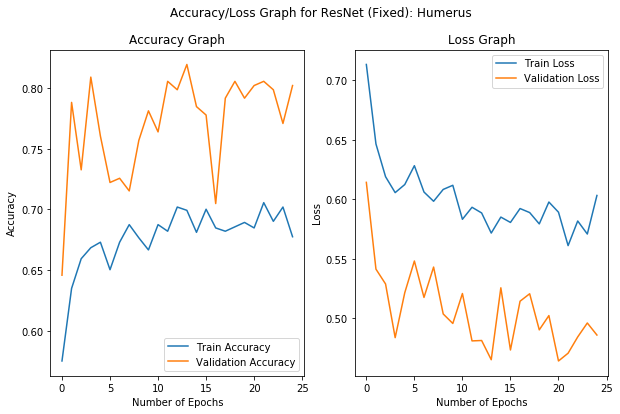

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for ResNet (Fixed): Humerus")

Test Loss:  0.2509176

Test Accuracy: 70% (118/167)
confusion matrix: [[67 35]
 [14 51]]
Recall Score: 0.5930232558139535
Precision Score: 0.7846153846153846
F1 Score: 0.675496688741722


Text(33.0, 0.5, 'Predicted Values')

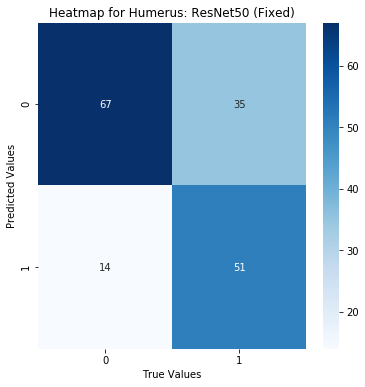

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_resnet, criterion)
print("confusion matrix:",cm)
r=recall_score(actual_list,predicted_list)
p=precision_score(actual_list,predicted_list)
print("Recall Score:",r)
print("Precision Score:",p)
print("F1 Score:",(2*p*r)/(p+r))
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Humerus: ResNet50 (Fixed)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")

In [0]:
# Save Model
torch.save(model_trained_resnet.state_dict(),os.path.join(data_dir,'resnet50_Humerus.pth'))

## VGG

In [0]:
vgg16=models.vgg16(pretrained=True)
print(vgg16.classifier[6].in_features)
# Freeze training for all layers
for param in vgg16.features.parameters():  
    param.require_grad = False
    
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=len(class_names))
#print(vgg16)
if device:
    vgg16.cuda() 

criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(vgg16.classifier[-1].parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 109968170.30it/s]


4096


In [0]:
model_trained_vgg,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(vgg16, criterion, optimizer,num_epochs=25)

Epoch 1/25
----------
train loss: 0.7001, acc: 0.5507
validate loss: 0.6260, acc: 0.6319
Epoch 2/25
----------
train loss: 0.6306, acc: 0.6250
validate loss: 0.6407, acc: 0.5868
Epoch 3/25
----------
train loss: 0.6141, acc: 0.6685
validate loss: 0.6017, acc: 0.6806
Epoch 4/25
----------
train loss: 0.5900, acc: 0.6875
validate loss: 0.5943, acc: 0.6875
Epoch 5/25
----------
train loss: 0.5623, acc: 0.7138
validate loss: 0.5998, acc: 0.6910
Epoch 6/25
----------
train loss: 0.5676, acc: 0.7219
validate loss: 0.5923, acc: 0.7188
Epoch 7/25
----------
train loss: 0.5982, acc: 0.6803
validate loss: 0.5542, acc: 0.7257
Epoch 8/25
----------
train loss: 0.5515, acc: 0.7201
validate loss: 0.5395, acc: 0.7361
Epoch 9/25
----------
train loss: 0.5292, acc: 0.7373
validate loss: 0.4832, acc: 0.7882
Epoch 10/25
----------
train loss: 0.5149, acc: 0.7582
validate loss: 0.5174, acc: 0.7604
Epoch 11/25
----------
train loss: 0.4935, acc: 0.7582
validate loss: 0.6263, acc: 0.7083
Epoch 12/25
-------

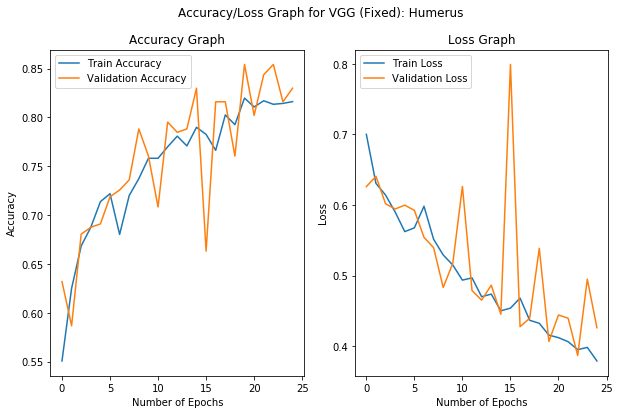

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for VGG (Fixed): Humerus")

Test Loss:  0.24420808

Test Accuracy: 74% (125/167)
confusion matrix: [[70 31]
 [11 55]]
F1 Score: 0.7236842105263159


Text(33.0, 0.5, 'Predicted Values')

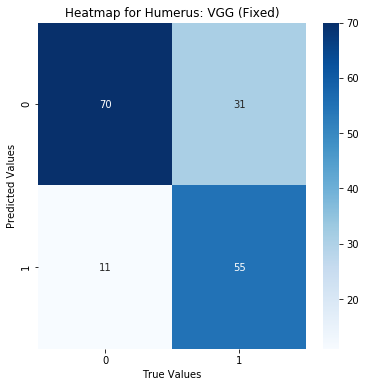

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_vgg, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1)    
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Humerus: VGG (Fixed)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")

In [0]:
# Save Model
  torch.save(model_trained_vgg.state_dict(),os.path.join(data_dir,'fixed_vgg_Humerus.pth'))

## AlexNet

In [0]:
alexnet = models.alexnet(pretrained=True)
for param in alexnet.features.parameters():  
    param.require_grad = False
    
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs,len(class_names))

if device:
    alexnet.cuda() 
    
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(alexnet.classifier[6].parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:09<00:00, 25571808.41it/s]


In [0]:
model_trained_alexnet,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(alexnet, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6940, acc: 0.5562
validate loss: 0.6787, acc: 0.5625
Epoch 2/25
----------
train loss: 0.6789, acc: 0.5842
validate loss: 0.7180, acc: 0.5347
Epoch 3/25
----------
train loss: 0.6659, acc: 0.5842
validate loss: 0.6401, acc: 0.6250
Epoch 4/25
----------
train loss: 0.6512, acc: 0.6159
validate loss: 0.6643, acc: 0.5972
Epoch 5/25
----------
train loss: 0.6475, acc: 0.6150
validate loss: 0.7088, acc: 0.6042
Epoch 6/25
----------
train loss: 0.6402, acc: 0.6159
validate loss: 0.5995, acc: 0.6562
Epoch 7/25
----------
train loss: 0.6249, acc: 0.6476
validate loss: 0.5790, acc: 0.6562
Epoch 8/25
----------
train loss: 0.6227, acc: 0.6504
validate loss: 0.6341, acc: 0.6007
Epoch 9/25
----------
train loss: 0.6050, acc: 0.6621
validate loss: 0.6086, acc: 0.6528
Epoch 10/25
----------
train loss: 0.6012, acc: 0.6639
validate loss: 0.5433, acc: 0.7326
Epoch 11/25
----------
train loss: 0.6044, acc: 0.6630
validate loss: 0.5885, acc: 0.6701
Epoch 12/25
-------

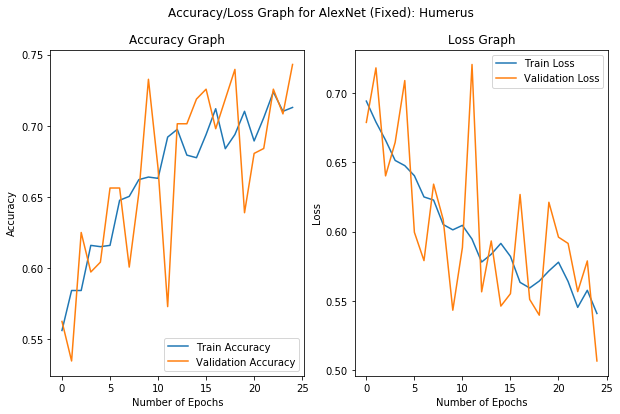

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for AlexNet (Fixed): Humerus")

Test Loss:  0.25910166

Test Accuracy: 67% (113/167)
confusion matrix: [[67 40]
 [14 46]]
F1 Score: 0.6301369863013698


Text(33.0, 0.5, 'Predicted Values')

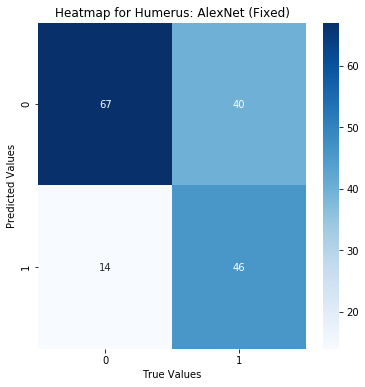

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_alexnet, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1) 
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Humerus: AlexNet (Fixed)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")

In [0]:
# Save Model
torch.save(model_trained_alexnet.state_dict(),os.path.join(data_dir,'fixed_alexnet_Humerus.pth'))

## GoogleNet

In [0]:
google = models.inception_v3(pretrained=True) 
num_ftrs = google.fc.in_features 
for param in google.parameters(): 
    param.require_grad = False

google.fc = nn.Linear(num_ftrs,2)

google = google.cuda()
criterion = nn.CrossEntropyLoss()

google.aux_logits=False
optimizer_ft = optim.SGD(google.fc.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:05<00:00, 20635489.02it/s]


In [0]:
model_trained_google,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(google, criterion, optimizer_ft, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6874, acc: 0.5589
validate loss: 0.6481, acc: 0.5833
Epoch 2/25
----------
train loss: 0.6443, acc: 0.6304
validate loss: 0.5821, acc: 0.7257
Epoch 3/25
----------
train loss: 0.6222, acc: 0.6667
validate loss: 0.5454, acc: 0.7153
Epoch 4/25
----------
train loss: 0.6094, acc: 0.6793
validate loss: 0.5036, acc: 0.7604
Epoch 5/25
----------
train loss: 0.6073, acc: 0.6730
validate loss: 0.4816, acc: 0.7986
Epoch 6/25
----------
train loss: 0.5890, acc: 0.6821
validate loss: 0.4944, acc: 0.7535
Epoch 7/25
----------
train loss: 0.5474, acc: 0.7355
validate loss: 0.5102, acc: 0.7361
Epoch 8/25
----------
train loss: 0.5930, acc: 0.6975
validate loss: 0.4504, acc: 0.8056
Epoch 9/25
----------
train loss: 0.5496, acc: 0.7292
validate loss: 0.4217, acc: 0.8368
Epoch 10/25
----------
train loss: 0.5691, acc: 0.7264
validate loss: 0.4599, acc: 0.7951
Epoch 11/25
----------
train loss: 0.5442, acc: 0.7328
validate loss: 0.4163, acc: 0.8507
Epoch 12/25
-------

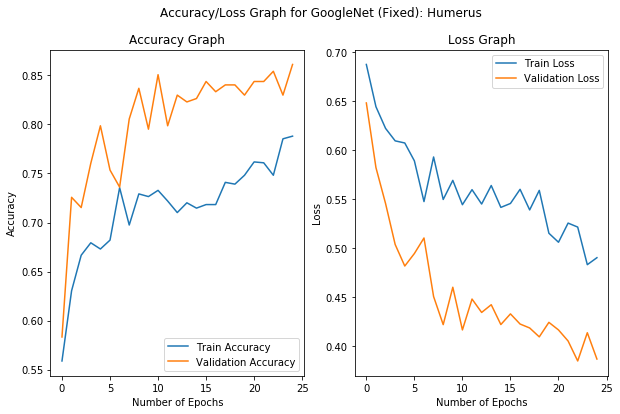

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for GoogleNet (Fixed): Humerus")

Test Loss:  0.19799705

Test Accuracy: 80% (134/167)
confusion matrix: [[70 22]
 [11 64]]
F1 Score: 0.7950310559006211


Text(33.0, 0.5, 'Predicted Values')

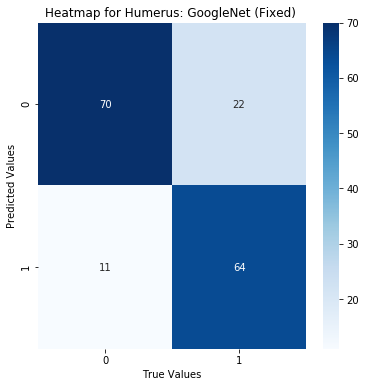

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_google, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1) 
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Humerus: GoogleNet (Fixed) ")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")

In [0]:
# Save Model
torch.save(model_trained_google.state_dict(),os.path.join(data_dir,'fixed_google_Humerus.pth'))

# Finetuned

## Resnet50

In [0]:
model_resnet_50_fine = models.resnet50(pretrained=True).cuda()
  
model_resnet_50_fine.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).cuda()
 
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(model_resnet_50_fine.parameters(), lr=0.001, momentum=0.9)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 96558215.35it/s]


In [0]:
model_trained_resnet_50_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(model_resnet_50_fine, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6499, acc: 0.6051
validate loss: 0.5034, acc: 0.7569
Epoch 2/25
----------
train loss: 0.5885, acc: 0.7038
validate loss: 0.4486, acc: 0.8056
Epoch 3/25
----------
train loss: 0.5489, acc: 0.7337
validate loss: 0.4517, acc: 0.8264
Epoch 4/25
----------
train loss: 0.5462, acc: 0.7364
validate loss: 0.4774, acc: 0.8056
Epoch 5/25
----------
train loss: 0.5254, acc: 0.7337
validate loss: 0.5005, acc: 0.7847
Epoch 6/25
----------
train loss: 0.5400, acc: 0.7418
validate loss: 0.4586, acc: 0.8090
Epoch 7/25
----------
train loss: 0.5072, acc: 0.7645
validate loss: 0.4239, acc: 0.8264
Epoch 8/25
----------
train loss: 0.5085, acc: 0.7509
validate loss: 0.3934, acc: 0.8403
Epoch 9/25
----------
train loss: 0.4923, acc: 0.7736
validate loss: 0.3941, acc: 0.8299
Epoch 10/25
----------
train loss: 0.5143, acc: 0.7708
validate loss: 0.3590, acc: 0.8507
Epoch 11/25
----------
train loss: 0.4736, acc: 0.7763
validate loss: 0.4070, acc: 0.8333
Epoch 12/25
-------

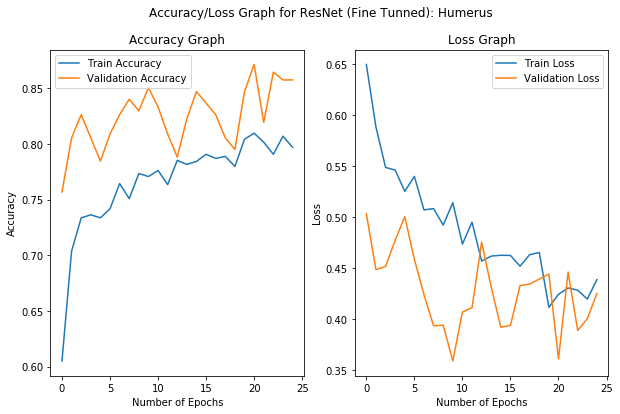

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for ResNet (Fine Tunned): Humerus")

Test Loss:  0.20365879

Test Accuracy: 85% (142/167)
confusion matrix: [[71 15]
 [10 71]]
F1 Score: 0.8502994011976048


Text(33.0, 0.5, 'Predicted Values')

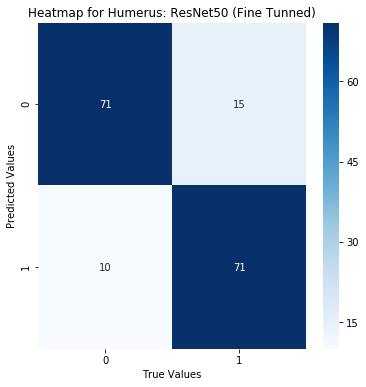

In [0]:
cm,predicted_list, actual_list=testModel(model_trained_resnet_50_fine, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1) 
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Humerus: ResNet50 (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")

In [0]:
# Save Model
torch.save(model_trained_resnet_50_fine.state_dict(),os.path.join(data_dir,'50_Humerus.pth'))

## VGG

In [0]:
vgg16_fine=models.vgg16(pretrained=True)
print(vgg16_fine.classifier[6].in_features)
    
vgg16_fine.classifier[-1] = nn.Linear(in_features=4096, out_features=len(class_names))
#print(vgg16)
if device:
    vgg16_fine.cuda() 

criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(vgg16_fine.parameters(), lr=0.001, momentum=0.9)

4096


In [0]:
model_trained_vgg_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(vgg16_fine, criterion, optimizer,num_epochs=25)

Epoch 1/25
----------
train loss: 0.6728, acc: 0.6069
validate loss: 0.6442, acc: 0.6285
Epoch 2/25
----------
train loss: 0.5998, acc: 0.6703
validate loss: 0.6023, acc: 0.6597
Epoch 3/25
----------
train loss: 0.5846, acc: 0.6902
validate loss: 0.5743, acc: 0.7188
Epoch 4/25
----------
train loss: 0.5779, acc: 0.7002
validate loss: 0.5498, acc: 0.7292
Epoch 5/25
----------
train loss: 0.5688, acc: 0.7201
validate loss: 0.5819, acc: 0.6875
Epoch 6/25
----------
train loss: 0.5581, acc: 0.7228
validate loss: 0.5313, acc: 0.7639
Epoch 7/25
----------
train loss: 0.5230, acc: 0.7572
validate loss: 0.5520, acc: 0.7500
Epoch 8/25
----------
train loss: 0.5243, acc: 0.7310
validate loss: 0.5019, acc: 0.7743
Epoch 9/25
----------
train loss: 0.5121, acc: 0.7382
validate loss: 0.5206, acc: 0.7917
Epoch 10/25
----------
train loss: 0.5085, acc: 0.7455
validate loss: 0.4898, acc: 0.8021
Epoch 11/25
----------
train loss: 0.5055, acc: 0.7473
validate loss: 0.4769, acc: 0.8090
Epoch 12/25
-------

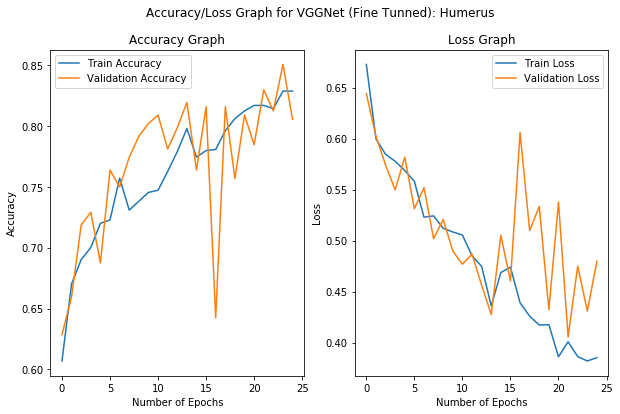

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for VGGNet (Fine Tunned): Humerus")

Test Loss:  0.2234288

Test Accuracy: 80% (135/167)
confusion matrix: [[70 21]
 [11 65]]
F1 Score: 0.8024691358024691


Text(33.0, 0.5, 'Predicted Values')

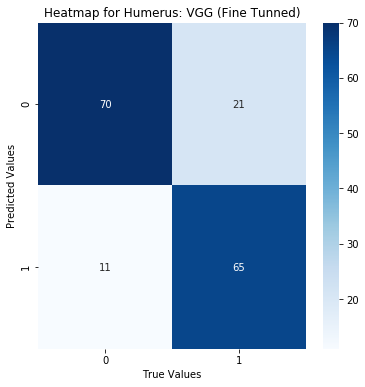

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_vgg_fine, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1) 
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Humerus: VGG (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")


In [0]:
# Save Model
  torch.save(model_trained_vgg_fine.state_dict(),os.path.join(data_dir,'fine_vgg_Humerus.pth'))

## AlexNet

In [0]:
alexnet_fine = models.alexnet(pretrained=True)

num_ftrs = alexnet_fine.classifier[6].in_features
alexnet_fine.classifier[6] = nn.Linear(num_ftrs,len(class_names))

if device:
    alexnet_fine.cuda() 
    
criterion = nn.CrossEntropyLoss()
optimizer =optim.SGD(alexnet_fine.parameters(), lr=0.001, momentum=0.9)


In [0]:
model_trained_alexnet_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(alexnet_fine, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train loss: 0.7038, acc: 0.5543
validate loss: 0.7245, acc: 0.4931
Epoch 2/25
----------
train loss: 0.6644, acc: 0.6069
validate loss: 0.7044, acc: 0.5139
Epoch 3/25
----------
train loss: 0.6576, acc: 0.6051
validate loss: 0.7030, acc: 0.5660
Epoch 4/25
----------
train loss: 0.6363, acc: 0.6304
validate loss: 0.6365, acc: 0.6250
Epoch 5/25
----------
train loss: 0.6407, acc: 0.6449
validate loss: 0.6608, acc: 0.6354
Epoch 6/25
----------
train loss: 0.6344, acc: 0.6467
validate loss: 0.5907, acc: 0.6771
Epoch 7/25
----------
train loss: 0.6518, acc: 0.6168
validate loss: 0.6826, acc: 0.5556
Epoch 8/25
----------
train loss: 0.6398, acc: 0.6286
validate loss: 0.6070, acc: 0.6562
Epoch 9/25
----------
train loss: 0.6167, acc: 0.6603
validate loss: 0.6120, acc: 0.6667
Epoch 10/25
----------
train loss: 0.6064, acc: 0.6630
validate loss: 0.5905, acc: 0.6562
Epoch 11/25
----------
train loss: 0.6040, acc: 0.6739
validate loss: 0.6185, acc: 0.6528
Epoch 12/25
-------

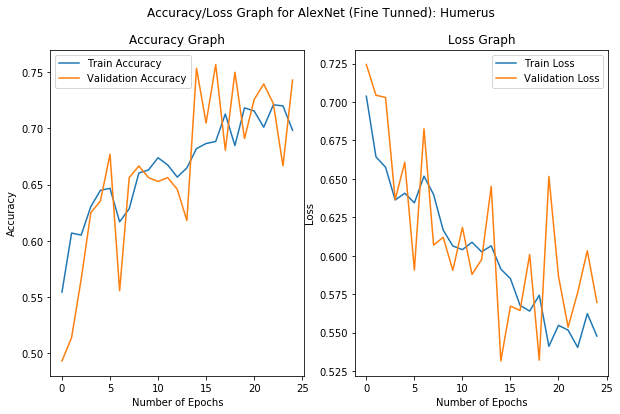

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for AlexNet (Fine Tunned): Humerus")

Test Loss:  0.24773513

Test Accuracy: 72% (121/167)
confusion matrix: [[66 31]
 [15 55]]
F1 Score: 0.7051282051282051


Text(33.0, 0.5, 'Predicted Values')

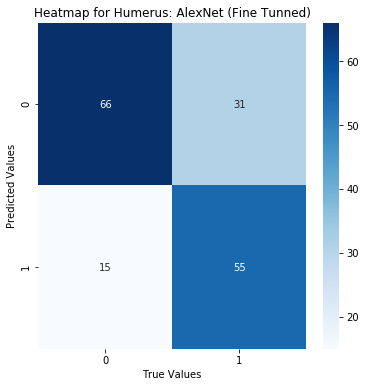

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_alexnet_fine, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1) 
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap='Blues')
ax.set_title("Heatmap for Humerus: AlexNet (Fine Tunned)")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")



In [0]:
# Save Model
torch.save(model_trained_alexnet_fine.state_dict(),os.path.join(data_dir,'fine_alexnet_Humerus.pth'))

## GoogleNet

In [0]:
google_fine = models.inception_v3(pretrained=True) 
num_ftrs = google_fine.fc.in_features 

google_fine.fc = nn.Linear(num_ftrs,2)

google_fine = google_fine.cuda()

criterion = nn.CrossEntropyLoss()

google_fine.aux_logits=False
optimizer_ft = optim.SGD(google_fine.parameters(), lr=0.0001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [0]:
model_trained_google_fine,train_loss_list,train_acc_list,val_loss_list,val_acc_list,f1_score_list = train_model(google_fine, criterion, optimizer_ft, num_epochs=25)

Epoch 1/25
----------
train loss: 0.6953, acc: 0.5335
validate loss: 0.6345, acc: 0.6250
Epoch 2/25
----------
train loss: 0.6456, acc: 0.6159
validate loss: 0.5748, acc: 0.7153
Epoch 3/25
----------
train loss: 0.6316, acc: 0.6458
validate loss: 0.5327, acc: 0.7535
Epoch 4/25
----------
train loss: 0.6090, acc: 0.6803
validate loss: 0.5070, acc: 0.7639
Epoch 5/25
----------
train loss: 0.6020, acc: 0.6721
validate loss: 0.5204, acc: 0.7535
Epoch 6/25
----------
train loss: 0.5918, acc: 0.6803
validate loss: 0.4886, acc: 0.7986
Epoch 7/25
----------
train loss: 0.5687, acc: 0.7065
validate loss: 0.4718, acc: 0.8333
Epoch 8/25
----------
train loss: 0.5714, acc: 0.7092
validate loss: 0.4847, acc: 0.7674
Epoch 9/25
----------
train loss: 0.5479, acc: 0.7201
validate loss: 0.4813, acc: 0.7951
Epoch 10/25
----------
train loss: 0.5441, acc: 0.7120
validate loss: 0.4594, acc: 0.8160
Epoch 11/25
----------
train loss: 0.5496, acc: 0.7210
validate loss: 0.4483, acc: 0.8090
Epoch 12/25
-------

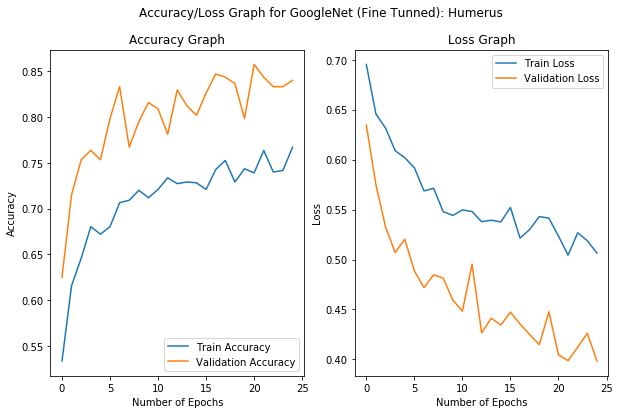

In [0]:
plotGraph(train_acc_list,val_acc_list,train_loss_list,val_loss_list,"Accuracy/Loss Graph for GoogleNet (Fine Tunned): Humerus")

Test Loss:  0.22412768

Test Accuracy: 82% (137/167)
confusion matrix: [[74 23]
 [ 7 63]]
F1 Score: 0.8076923076923077


Text(33.0, 0.5, 'Predicted Values')

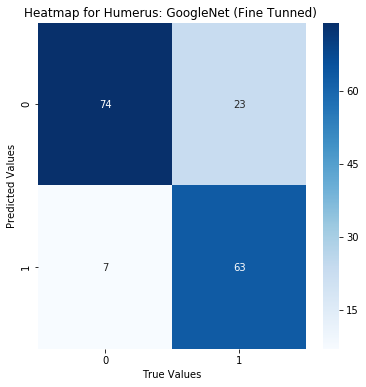

In [0]:
# Test Model
cm,predicted_list, actual_list=testModel(model_trained_google_fine, criterion)
print("confusion matrix:",cm)
precision=precision_score(predicted_list, actual_list)
recall=recall_score(predicted_list, actual_list)
f1=(2*precision*recall)/(precision+recall)
print("F1 Score:",f1) 
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
ax.set_title("Heatmap for Humerus: GoogleNet (Fine Tunned) ")
ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")

In [0]:
# Save Model
torch.save(model_trained_google_fine.state_dict(),os.path.join(data_dir,'fine_google_Humerus.pth'))